Import Libraries

In [1]:
import jax
import optax
import time
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

PINNs Network

In [2]:
n_nodes = 10

class PINNs(nn.Module):
  """PINNs"""
  def setup(self):
    self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]


  @nn.compact
  def __call__(self, inputs):
      # split the two variables, probably just by slicing
      x, w = inputs[:,0:1], inputs[:,1:2]
      
      def get_u(x,w):
#         u = jnp.hstack([x,w])
        u = x
        for i, lyr in enumerate(self.layers):
          u = lyr(u)
        return u

      u = get_u(x, w)

      # obtain u_x
      def get_u_x(get_u, x, w):
        u_x = jacfwd(get_u)(x, w)
        return u_x
      u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
      u_x = u_x_vmap(get_u, x, w).reshape(-1,1)  
      #obtain u_xx    
      def get_u_xx(get_u, x, w):
        u_xx = hessian(get_u)(x,w)
        return u_xx
      u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
      u_xx = u_xx_vmap(get_u, x, w).reshape(-1,1)      
      action = jnp.hstack([u,u_x, u_xx])   
      return action


In [3]:
model = PINNs()
# params = model.init(random.PRNGKey(0), jnp.zeros([2,1]))

In [4]:
seed = 0
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,1]) # Dummy input
params = model.init(key2, a) # Initialization call
# jax.tree_map(lambda a: a.shape, params) # Checking output shapes
# model.apply(params, a)
# num_params, format_params_fn = get_params_format_fn(params)
params

FrozenDict({
    params: {
        layers_0: {
            kernel: DeviceArray([[ 0.42931974,  0.44043028,  0.40724975,  0.5920474 ,
                           0.35924262, -0.26018986, -0.17083684, -0.04383535,
                          -0.55320156, -0.04911241]], dtype=float32),
            bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
        },
        layers_2: {
            kernel: DeviceArray([[-0.10643526, -0.33458424, -0.31936586, -0.10162847,
                          -0.3434626 ,  0.2522192 ,  0.32469654, -0.39344093,
                           0.11392509,  0.20166366],
                         [ 0.50698286, -0.39070815,  0.28065586,  0.35078502,
                           0.30270684, -0.5174967 , -0.04673991,  0.50925744,
                           0.03883834,  0.31939563],
                         [ 0.48460272, -0.5359312 ,  0.1574139 , -0.326109  ,
                           0.35532957,  0.36741516, -0.04490673,  0.11889929,
                  

Functions

In [5]:
# Function to generate analytical solution
def eval_u(x, Pe, L):
    u = (1. - jnp.exp(Pe*x/L)) / (1. - jnp.exp(Pe))
    return u

def eval_Pe(u, k, L):
    return u*L/k

# f: IC/BC
def tf_bc(x):
    u = (1. - jnp.exp(Pe*x/L)) / (1. - jnp.exp(Pe))
    return u

Hyper parameters and data 

In [6]:
# We prepare the data
# choose v (PDE parameter)
v = 6
# fixed PDE & BC parameters k & L
k = 1.
L = 1.
Pe = eval_Pe(v, k, L)
lmbda = 1 #500
# Domain Boundary
x_l, x_u = 0, L
n = 10000

# t_fitness = 0


In [7]:
x_pde = jnp.linspace(x_l, x_u, n)
# PDE Data
# shape (1000, 2)
data_pde = jnp.hstack([x_pde.reshape(-1, 1), jnp.ones((len(x_pde), 1))])
# samples, features = data_pde.shape
# shape (1000, 1)
labels_pde = jnp.reshape(eval_u(x_pde, Pe, L),(-1, 1))
# b = model.apply(params, data_pde)

Loss Function

In [8]:
def make_mse_func(input):
  def mse(params):
    # Define the squared loss for a single pair (x,y)
    def squared_error(input):
      x = input[:,0:1]
      
      pred = model.apply(params, input)
      u, u_x, u_xx = pred[:,0:1], pred[:,1:2], pred[:,2:3]
      # ground truth
      t_u = tf_bc(x)
      _bc = jnp.where((jnp.equal(x, x_l)|jnp.equal(x, x_u)), 1, 0)
      # _bc = ( jnp.equal(x, x_l) | jnp.equal(x, x_u) )
      bc_mse = jnp.sum(jnp.square((t_u-u)*_bc))/jnp.sum(_bc)
      # PDE (physics laws): v*u_x = k*u_xx  
      pde = v*u_x - k*u_xx 
      # exclude BC points
      _pde = jnp.where((jnp.equal(x, x_l)|jnp.equal(x, x_u)), 0, 1)
      pde = pde*_pde
      pde_mse = jnp.sum(jnp.square(pde))/jnp.sum(_pde)
      pde_mse = pde_mse / lmbda  
      loss = pde_mse + bc_mse
      return loss
    return squared_error(input)
  return jax.jit(mse) # And finally we jit the result.

# Get the sampled loss
loss = make_mse_func(data_pde)

Weights Update

In [9]:
def update(params, opt_state):
#     start = time.time()  
    loss_value, grad = jax.value_and_grad(loss)(params)
#     end = time.time()
#     global t_fitness
#     t_fitness = t_fitness + (end-start)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value
update = jit(update)

Optimizer

In [10]:
alpha = 0.001
# optimizer = optax.adam(learning_rate=alpha) # Choose the method
optimizer = optax.sgd(learning_rate=alpha) # Choose the method
opt_state = optimizer.init(params)
loss_grad_fn = jax.value_and_grad(loss)

Training 

In [11]:
# start_time = time.perf_counter()
max_iters = 500000
loss_ls = []
t_training = []
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    start = time.time()
    params, opt_state, loss_value = update(params, opt_state)
    end = time.time()
    t_training.append(end-start)
    loss_ls.append(loss_value)
    runtime += (end-start)
    train_iters += 1    
#     print('Loss step {}: '.format(train_iters), loss_value)
# print('time cost: {}s'.format(time.perf_counter() - start_time))
# print ("...\nFitness Evaluation time: %d mins %d secs!" %((t_fitness)/60, jnp.remainder(t_fitness, 60)))

In [12]:
import numpy as np
training_ls = np.cumsum(t_training)
training_ls

array([ 2.2978785 ,  2.29833126,  2.2986865 , ..., 59.99942708,
       59.99983025, 60.00023603])

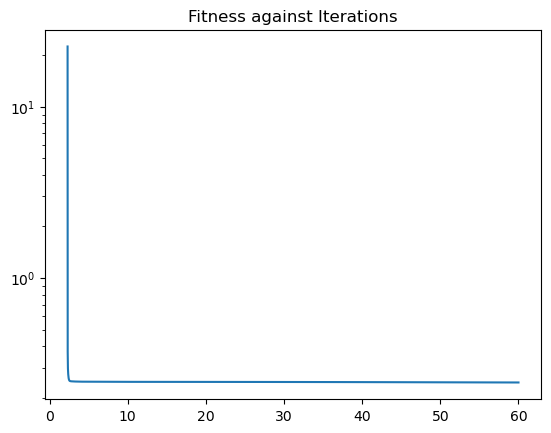

In [13]:
plt.plot(training_ls, loss_ls); plt.yscale('log');
# plt.xlim(800,1000)
# plt.ylim(-1e6,0)
plt.title('Fitness against Iterations')
plt.show()

In [14]:
import pandas as pd

df = pd.DataFrame({'Training Time': training_ls, 'Loss': loss_ls})
#df.to_csv('diffusion_sgd_%d.csv'%(seed), index=False)
df

,Training Time,Loss
0,2.297879,22.529116
1,2.298331,4.9869494
2,2.298687,1.8609338
3,2.299029,0.98197985
4,2.299354,0.70618796
...,...,...
141262,59.998613,0.24532457
141263,59.999019,0.24532449
141264,59.999427,0.24532442
141265,59.999830,0.24532448


In [15]:
hello = PINNs()
prediction = hello.apply(params, data_pde)
u = prediction[:,0:1]

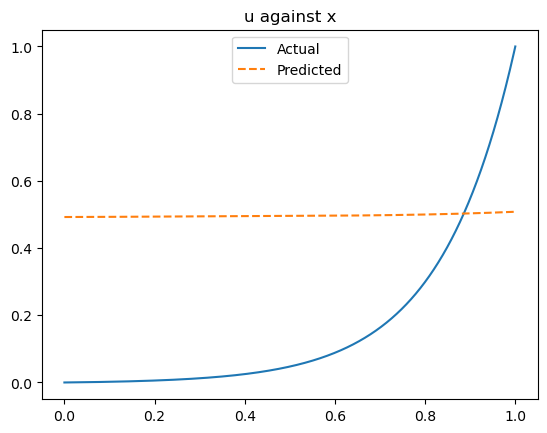

In [17]:
plt.plot(x_pde, labels_pde, label = "Actual")
plt.plot(x_pde, u, '--', label = "Predicted")

leg = plt.legend(loc='upper center')
plt.title('u against x')
plt.show()

In [18]:
jnp.mean(jnp.square(labels_pde - u))

DeviceArray(0.16489194, dtype=float32)

In [19]:
np.save('diffusion_sgd_60s', (u, labels_pde))